# Real-World Data Demonstration

### Team Epsilon-Greedy Quants
#### Michael Lee, Nikat Patel, Jose Antonio Alatorre Sanchez

This notebook contains code for detrending time series data.

In [1]:
from environments.e_greedy import DeepTradingEnvironment, LinearAgent

import datetime
import numpy as np
import pandas as pd
import os
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.cla import CLA
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
import quantstats as qs
qs.extend_pandas()
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from scipy.signal import detrend
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
import pylab 

In [2]:
root = os.getcwd()
data_env = root+"/data_env/"

# Utility Functions

In [3]:
def _retrieve_asset_dict():
    # obtain close prices from parquet files of ETF price history
    root = os.getcwd()
    data_env = root+"/data_env/"
    files = [_ for _ in os.listdir(data_env) if "parquet" in _]
    assets_dict = {file: pd.read_parquet(data_env + "/" + file) for file in files}
    counter=0
    for key, value in assets_dict.items():
        if counter==0:
            main_index=value.index
    else:
        main_index=main_index.join(value.index,how="inner")
        
    for key, value in assets_dict.items():
        tmp_df=value.reindex(main_index)
        tmp_df=tmp_df.fillna(method='ffill')
        assets_dict[key]=tmp_df['close']
    return assets_dict

def build_portfolio_df(asset_dict):
    portfolio_df = pd.DataFrame()
    
    for key, value in assets_dict.items():
        key = key.split(".")[0]
        tmp_df = pd.DataFrame(data=value)
        tmp_df.columns=[key]
        portfolio_df = pd.concat([portfolio_df, tmp_df], axis=1)
        
    portfolio_df.index = pd.to_datetime(portfolio_df.index, errors='coerce')
    return portfolio_df

In [4]:
def plot_backtest(linear_agent_train, env_test, test_input, model_run, model):
    ## Create plot of backtest returns
    if not "backtest" in locals():
        backtest=None
    benchmark_min_volatility, benchmark_max_sharpe, benchmark_max_return = \
        linear_agent_train._run_benchmarks(test_input, df_start="2020-04-15", df_end="2020-11-13", benchmark_start="2020-05-01")
    backtest, tmp_weights =linear_agent_train.backtest_policy(epoch=1,backtest=backtest, env_test=env_test, test_input=test_input)
    backtest = backtest["2020-05-01":]
    plt.figure(figsize=(12, 6))
    backtest_return = round((backtest[1][-1] - 1) * 100, 2)
    backtest_volatility = round(backtest[1].std() * 100, 2)
    plt.plot(backtest, color="blue", label="Test Data - Return: {}%, Volatility: {}%".format(str(backtest_return), str(backtest_volatility)))
    # plot benchmarks
    plt.plot(benchmark_max_return, color="black", label="Real Dataset Benchmark - Max Return, Return: {}%, Volatility: {}%".format(round((benchmark_max_return[-1] - 1) * 100, 2), round(benchmark_max_return.std() * 100, 2)))    
    plt.plot(benchmark_max_sharpe, color="orange", label="Real Dataset Benchmark - Max Sharpe, Return: {}%, Volatility: {}%".format(round((benchmark_max_sharpe[-1] - 1) * 100, 2), round(benchmark_max_sharpe.std() * 100, 2))) 
    plt.plot(benchmark_min_volatility, color="green",  label="Real Dataset Benchmark - Min Volatility, Return: {}%, Volatility: {}%".format( round((benchmark_min_volatility[-1] - 1) * 100, 2), round(benchmark_min_volatility.std() * 100, 2)))
    plt.gcf().autofmt_xdate()
    plt.xticks(fontsize=linear_agent_train.tick_size)
    plt.yticks(fontsize=linear_agent_train.tick_size)
    plt.xlabel("Date", fontsize = linear_agent_train.label_size)
    plt.ylabel("Backtest", fontsize = linear_agent_train.label_size)
    plt.title("Backtest on Test Data: "+ model,fontsize = linear_agent_train.title_size)
    plt.legend(loc="upper left")
    plt.savefig("{}/{}_test_backtest_plot_{}.png".format(linear_agent_train.model_run_dir, model_run, model))
    tmp_weights.to_csv(root+'/temp_persisted_data/'+model_run+"_test_backtest_weights_"+model+'.csv')
    plt.show()
    return backtest

# Reviewing Real-World Data

In [5]:
# read a sample ETF

data_env_two_asset = root+ "/data_env/"

pd.read_parquet(data_env_two_asset+'MTUM.parquet').head()



,open,high,low,close,volume
index,,,,,
2017-01-03 05:00:00+00:00,72.59413,72.90881,72.21272,72.54646,297832
2017-01-04 05:00:00+00:00,72.69902,73.09952,72.69902,72.97556,225891
2017-01-05 05:00:00+00:00,72.98509,73.25208,72.84206,73.21394,412561
2017-01-06 05:00:00+00:00,73.20441,73.77654,73.04230,73.63351,260918
2017-01-09 05:00:00+00:00,73.66212,73.76701,73.50001,73.60490,165800


In [9]:
# create a portfolio
assets_dict = _retrieve_asset_dict()
portfolio_df = build_portfolio_df(assets_dict)
# portfolio_df=portfolio_df.rename(columns = {'USMV':'Simulated Asset'})

In [10]:
# create a train dataset and de-mean the time series

portfolio_df_train = portfolio_df[portfolio_df.index >= '2019-02-01']
portfolio_df_train = portfolio_df_train[portfolio_df_train.index <= '2020-02-01']
portfolio_df_train.sub(portfolio_df_train.mean())

portfolio_df_train.head()

,EEMV,EFAV,MTUM,QUAL,SIZE,USMV,VLUE
index,,,,,,,
2019-02-01 05:00:00+00:00,56.97454,65.81750,104.3037,80.92102,82.16029,53.53375,75.94203
2019-02-04 05:00:00+00:00,57.07571,66.04416,104.4988,81.45429,82.55833,53.91000,76.15092
2019-02-05 05:00:00+00:00,57.62489,66.40305,104.6647,81.98756,82.92724,54.06436,76.22688
2019-02-06 05:00:00+00:00,57.06607,65.94972,104.7428,81.84212,82.83987,53.98718,76.46426
2019-02-07 05:00:00+00:00,56.75777,65.49639,104.2744,81.02767,82.37387,53.87141,75.39131


In [11]:
portfolio_df_train["MTUM"].index

DatetimeIndex(['2019-02-01 05:00:00+00:00', '2019-02-04 05:00:00+00:00',
               '2019-02-05 05:00:00+00:00', '2019-02-06 05:00:00+00:00',
               '2019-02-07 05:00:00+00:00', '2019-02-08 05:00:00+00:00',
               '2019-02-11 05:00:00+00:00', '2019-02-12 05:00:00+00:00',
               '2019-02-13 05:00:00+00:00', '2019-02-14 05:00:00+00:00',
               ...
               '2020-01-17 05:00:00+00:00', '2020-01-21 05:00:00+00:00',
               '2020-01-22 05:00:00+00:00', '2020-01-23 05:00:00+00:00',
               '2020-01-24 05:00:00+00:00', '2020-01-27 05:00:00+00:00',
               '2020-01-28 05:00:00+00:00', '2020-01-29 05:00:00+00:00',
               '2020-01-30 05:00:00+00:00', '2020-01-31 05:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='index', length=252, freq=None)

In [13]:
portfolio_df_train.iloc[0]


EEMV     56.97454
EFAV     65.81750
MTUM    104.30370
QUAL     80.92102
SIZE     82.16029
USMV     53.53375
VLUE     75.94203
Name: 2019-02-01 05:00:00+00:00, dtype: float64

In [14]:
tick_size  = 14  # tick size
label_size = 18  # x, y size
title_size = 22  # title size

C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


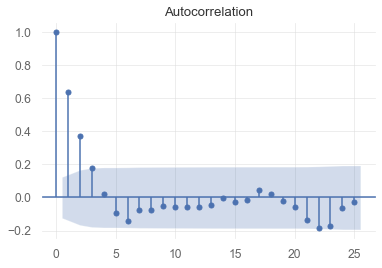

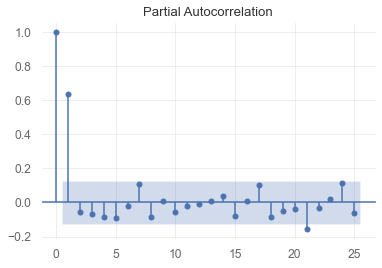

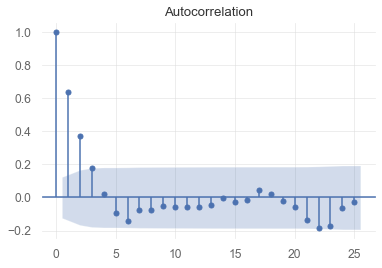

In [15]:
holtwinters = ExponentialSmoothing(portfolio_df_train["USMV"], trend="add", seasonal=None)

fit = holtwinters.fit(optimized=True, smoothing_level=0.2, smoothing_slope=0.10)

fit.__dict__
HW_predict = fit.predict(start=portfolio_df_train.iloc[0].name, end = portfolio_df_train.iloc[-1].name)

fit._results.trend # use as feature 
fit._results.level # use as feature 
fit._results.resid # use as feature 

import statsmodels.graphics.tsaplots as splt 
splt.plot_pacf(fit._results.resid)
splt.plot_acf(fit._results.resid)


In [17]:
fit._results.resid.std(ddof=0)

index
2019-02-01 05:00:00+00:00    53.776851
2019-02-04 05:00:00+00:00    53.819057
2019-02-05 05:00:00+00:00    53.929890
2019-02-06 05:00:00+00:00    54.052118
2019-02-07 05:00:00+00:00    54.133166
                               ...    
2020-01-27 05:00:00+00:00    66.889194
2020-01-28 05:00:00+00:00    66.886974
2020-01-29 05:00:00+00:00    66.957878
2020-01-30 05:00:00+00:00    66.957361
2020-01-31 05:00:00+00:00    67.059707
Length: 252, dtype: float64

In [18]:
portfolio_df_train.iloc[-1].name

Timestamp('2020-01-31 05:00:00+0000', tz='UTC')

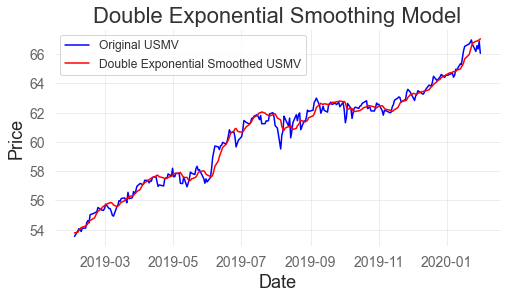

In [19]:
plt.figure(figsize=(8,4))

plt.plot(portfolio_df_train["USMV"], color = "blue", label = "Original USMV")
plt.plot(HW_predict, color ="red", label = "Double Exponential Smoothed USMV")
plt.legend(loc="upper left")
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.xlabel("Date", fontsize=label_size)
plt.ylabel("Price", fontsize=label_size)
plt.title("Double Exponential Smoothing Model", fontsize=title_size)
plt.show()
plt.close()

In [20]:
fit._results.resid

array([-0.24310139,  0.0909432 ,  0.13447001, -0.06493794, -0.26175554,
       -0.07631451, -0.1386754 ,  0.1904594 ,  0.18947805, -0.09487659,
        0.39344723,  0.33245734,  0.20948628,  0.08761971,  0.25850406,
       -0.06338855, -0.19421486, -0.27570161, -0.19065698,  0.03554187,
       -0.3726999 , -0.40241931, -0.62073645, -0.82157544, -0.76320512,
       -0.02593476,  0.08203022,  0.31148161,  0.15114308,  0.2610394 ,
        0.18937566, -0.03575284, -0.29702058,  0.42403563, -0.16034011,
       -0.1209139 ,  0.26176535, -0.00884656,  0.12357084,  0.35295335,
        0.41316029,  0.21090263,  0.04486845, -0.01135626,  0.1570011 ,
        0.02699696, -0.23253629, -0.13521216, -0.20964861,  0.00623519,
        0.00444754, -0.41359154, -0.74945097, -0.5575495 , -0.55754733,
        0.00574536,  0.03972459, -0.04043651,  0.24497334,  0.01312176,
        0.50545805, -0.22478207, -0.21356853,  0.02247367, -0.05069204,
       -0.73786077, -0.63349853, -0.51796878,  0.02071441, -0.64

In [21]:
sm.stats.acorr_ljungbox(fit._results.resid, return_df=True)

,lb_stat,lb_pvalue
1,103.013968,3.327936e-24
2,138.487174,8.470171e-31
3,146.572331,1.445846e-31
4,146.715277,1.029220e-30
5,149.011788,2.167030e-30
6,154.142157,1.029147e-30
7,155.612683,2.685923e-30
8,157.107382,6.435803e-30
9,157.809619,2.117087e-29
10,158.627629,6.220258e-29


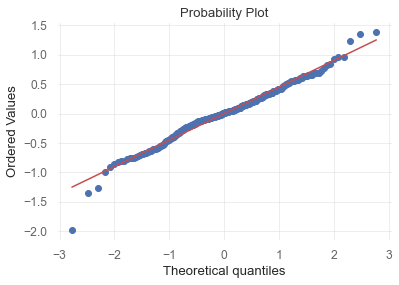

In [22]:
stats.probplot(fit._results.resid, dist="norm", plot=pylab)
pylab.show()